In [2]:
import os
import sys

from keras.models import Model, load_model
from keras.layers import Input, LSTM, GRU, Dense, Embedding, Bidirectional 
from keras.layers import RepeatVector, Concatenate, Activation, Dot, Lambda
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import keras.backend as K

import nltk
nltk.download('punkt')
from nltk.text import Text
from nltk.tokenize import word_tokenize

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Using TensorFlow backend.
[nltk_data] Downloading package punkt to /Users/laurie/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [12]:
#CONSTANTS

BATCH_SIZE = 32
EPOCHS = 50
HIDDEN_DIM_ENCODER = 400
HIDDEN_DIM_DECODER = 400 
MAX_TEXT_LENGTH = 100
EMBEDDING_DIM = 100
NUM_SAMPLES = 20000

In [4]:
train_csv = pd.read_csv('data/train_data.csv')
input_list = train_csv['inputs'].to_list()
target_list = train_csv['outputs'].to_list()

input_texts = [] # input sentences
target_texts = [] # target sentences 

t = 0
for i in range(len(input_list)):
    if t == NUM_SAMPLES:
        break
    if len(input_list[i]) >= MAX_TEXT_LENGTH or len(target_list[i]) >= MAX_TEXT_LENGTH:
        continue
    input_texts.append(input_list[i].rstrip())
    target_texts.append(target_list[i].rstrip())
    t += 1
    
m = len(input_texts) 
print("# of training samples: ", m)

# of training samples:  20000


In [5]:
# transform text to a sequence of word tokens
input_seq = [word_tokenize(i) for i in input_texts]
target_seq = [word_tokenize(i) for i in target_texts]

meta_seq = set([item for sublist in input_seq for item in sublist] + [item for sublist in target_seq for item in sublist] + ['<eos>','<sos>'])

# create a mapping from words to their indices
word2idx = {}
for i, word in enumerate(meta_seq):
    word2idx[word] = i
vocab_size = len(word2idx) + 1
print('vocab size: ', vocab_size)
# transform sequence of word tokens to sequence of word indices
input_indices = []
target_indices = []
target_indices_input = [] #target indices to be fed to decoder for teacher forcing

for seq in input_seq:
    indices = []
    for word in seq:
        indices.append(word2idx[word])
    input_indices.append(indices)

for seq in target_seq:
    indices = []
    for word in seq:
        indices.append(word2idx[word])
    target_indices.append(indices + [word2idx['<eos>']])
    target_indices_input.append([word2idx['<sos>']] + indices)


# determine length of longest input and target sequence
Tx = max(len(s) for s in input_indices)
Ty = max(len(s) for s in target_indices) 
print('Tx: ', Tx)
print('Ty: ', Ty)


vocab size:  15026
Tx:  30
Ty:  31


In [6]:
# pad sequences 
encoder_inputs = pad_sequences(input_indices, maxlen=Tx)
print("encoder_data.shape:", encoder_inputs.shape)

decoder_targets = pad_sequences(target_indices, maxlen=Ty, padding='post')

decoder_inputs = pad_sequences(target_indices_input, maxlen=Ty, padding='post')
print("decoder_data.shape:", decoder_inputs.shape)

encoder_data.shape: (20000, 30)
decoder_data.shape: (20000, 31)


In [7]:
# create mapping from word to pretrained 100-dim word vector from glove 
word2vec = {}
with open('glove/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:], dtype='float32')
        word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))

Found 400000 word vectors.


In [8]:
# create embedding matrix
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word2idx.items():
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


# create embedding layer
embedding_layer = Embedding(
  vocab_size,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  trainable=False  
)

In [9]:
# one-hot encode target sequences
decoder_targets_oh = np.zeros(
  (m, Ty, vocab_size),
  dtype='float32'
)

for i, d in enumerate(decoder_targets):
    for t, word in enumerate(d):
        if word > 0:
            decoder_targets_oh[i, t, word] = 1        

In [10]:
# custom softmax(axis = 1)
def softmax_over_time(x):
    assert(K.ndim(x) > 2)
    e = K.exp(x - K.max(x, axis=1, keepdims=True))
    s = K.sum(e, axis=1, keepdims=True)
    return e / s

# set up encoder
encoder_inputs_placeholder = Input(shape=(Tx,))
x = embedding_layer(encoder_inputs_placeholder)
encoder = Bidirectional(LSTM(
  HIDDEN_DIM_ENCODER,
  return_sequences=True,
  dropout=0.5 
))
encoder_outputs = encoder(x)

#pre attention decoder
decoder_inputs_placeholder = Input(shape=(Ty,))
decoder_inputs_x = embedding_layer(decoder_inputs_placeholder)

# attention
repeator = RepeatVector(Tx)
concatenator = Concatenate(axis=-1)
densor1 = Dense(10, activation='tanh')
densor2 = Dense(1, activation = softmax_over_time)
dotor = Dot(axes=1)

def one_step_attention(h, s_prev):
    """
    Arguments:
    h -- hidden state returned by encoder (m, Tx, 2*HIDDEN_DIM_ENCODER)
    s_prev -- previous hidden state of decoder (m, HIDDEN_DIM_DECODER)
    
    Returns: 
    context -- vector used as input to the next decoder cell
    """
    s_prev = repeator(s_prev)
    x = concatenator([h, s_prev])
    x = densor1(x)
    alphas = densor2(x)
    context = dotor([alphas, h])

    return context

#post attention decoder
decoder_lstm = LSTM(HIDDEN_DIM_DECODER, return_state=True)
decoder_dense = Dense(vocab_size, activation='softmax')

initial_s = Input(shape=(HIDDEN_DIM_DECODER,), name='s0')
initial_c = Input(shape=(HIDDEN_DIM_DECODER,), name='c0')
context_prev_word_concatenator = Concatenate(axis=2)

In [11]:
s = initial_s
c = initial_c

outputs = []
for t in range(Ty): 
    context = one_step_attention(encoder_outputs, s)
    selector = Lambda(lambda x: x[:, t:t+1])
    prev_word = selector(decoder_inputs_x)
    decoder_input = context_prev_word_concatenator([context, prev_word])
    o, s, c = decoder_lstm(decoder_input, initial_state=[s,c])
    decoder_outputs = decoder_dense(o)
    outputs.append(decoder_outputs)

def transpose(x):
    """
    Argument: 
    x -- outputs of decoder (Ty, m, vocab_size_target)
    
    Returns:
    x -- transposed version of outputs (m, Ty, vocab_size_target)
    """
    
    x = K.stack(x)
    x = K.permute_dimensions(x, pattern=(1,0,2))
    return x

permuter = Lambda(transpose)
outputs = permuter(outputs)

model = Model(inputs=[encoder_inputs_placeholder, decoder_inputs_placeholder, initial_s, initial_c], outputs=outputs)

def custom_loss(target, pred):
    mask = K.cast(target > 0, dtype='float32')
    res = mask * target * K.log(pred)
    return -K.sum(res) / K.sum(mask)

def acc(target, pred):
    target_ = K.argmax(target, axis=-1)
    pred_ = K.argmax(pred, axis=-1)
    res = K.cast(K.equal(target_, pred_), dtype='float32')
    #excluding padding from calculation
    mask = K.cast(K.greater(target_, 0), dtype='float32')
    res_correct = K.sum(mask * res)
    res_total = K.sum(mask)
    return res_correct / res_total
    
model.compile(optimizer='adam', loss=custom_loss, metrics=[acc])

In [13]:

#model = load_model('chatbot_model.h5', custom_objects={'softmax_over_time': softmax_over_time, 't': t})

states = np.zeros((m, HIDDEN_DIM_DECODER)) #initial hidden state and cell state
res = model.fit(
    [encoder_inputs, decoder_inputs, states, states], decoder_targets_oh,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.2
)

Train on 16000 samples, validate on 4000 samples
Epoch 1/50
16000/16000 [==============================] - 708s 44ms/step - loss: 5.7441 - acc: 0.1594 - val_loss: 5.6160 - val_acc: 0.2025
Epoch 2/50
16000/16000 [==============================] - 694s 43ms/step - loss: 5.3869 - acc: 0.2086 - val_loss: 5.5482 - val_acc: 0.2051
Epoch 3/50
16000/16000 [==============================] - 697s 44ms/step - loss: 5.2724 - acc: 0.2108 - val_loss: 5.4531 - val_acc: 0.2087
Epoch 4/50
16000/16000 [==============================] - 698s 44ms/step - loss: 5.1552 - acc: 0.2141 - val_loss: 5.3199 - val_acc: 0.2087
Epoch 5/50
16000/16000 [==============================] - 697s 44ms/step - loss: 5.0104 - acc: 0.2183 - val_loss: 5.1642 - val_acc: 0.2246
Epoch 6/50
16000/16000 [==============================] - 697s 44ms/step - loss: 4.7784 - acc: 0.2399 - val_loss: 4.9098 - val_acc: 0.2529
Epoch 7/50
16000/16000 [==============================] - 698s 44ms/step - loss: 4.5295 - acc: 0.2653 - val_loss: 4.7

In [14]:
model.save('model_50_epochs.h5')
model.save_weights('model_50_epochs_weights')

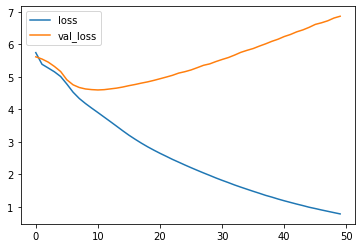

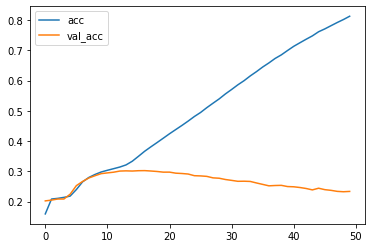

In [15]:
#plotting training results
plt.plot(res.history['loss'], label='loss')
plt.plot(res.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

plt.plot(res.history['acc'], label='acc')
plt.plot(res.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

In [16]:
#predictions model

#standalone encoder model
encoder_model = Model(encoder_inputs_placeholder, encoder_outputs)
encoder_to_attention = Input(shape=(Tx, HIDDEN_DIM_ENCODER*2))

decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = embedding_layer(decoder_inputs_single)

context = one_step_attention(encoder_to_attention, initial_s)
decoder_lstm_input = context_prev_word_concatenator([context, decoder_inputs_single_x])

o, s, c = decoder_lstm(decoder_lstm_input, initial_state=[initial_s, initial_c])
decoder_outputs = decoder_dense(o)

decoder_model = Model(inputs=[decoder_inputs_single, encoder_to_attention, initial_s, initial_c], outputs=[decoder_outputs, s, c])

In [17]:
idx2word = {i:w for w, i in word2idx.items()}

def predict_seq(input_seq):
    encoder_out = encoder_model.predict(input_seq.reshape(1,Tx))
    target_seq = np.zeros((1,1))
    target_seq[0,0] = word2idx['<sos>']
    
    eos = word2idx['<eos>'] #break if eos 
    
    s = np.zeros((1, HIDDEN_DIM_DECODER))
    c = np.zeros((1, HIDDEN_DIM_DECODER))
    
    output_sentence = []
    for _ in range(Ty):
        o, s, c = decoder_model.predict([target_seq, encoder_out, s, c])
        idx = np.argmax(o.flatten())
        if idx == eos:
            break
        word = ''
        if idx > 0:
            word = idx2word[idx]
            output_sentence.append(word)
        target_seq[0,0] = idx
        
    return ' '.join(output_sentence)

In [18]:
test_csv = pd.read_csv('data/test_data.csv')
test_texts = test_csv['Inputs'].to_list()
test_seq = [word_tokenize(i) for i in test_texts]
test_indices = []
for seq in test_seq:
    indices = []
    for word in seq:
        if word not in word2idx:
            indices.append(0)
        else:
            indices.append(word2idx[word])
    test_indices.append(indices)
test_inputs = pad_sequences(test_indices, maxlen=Tx)

In [23]:
test_outputs = []
for i in test_inputs:
    test_outputs.append(predict_seq(i))
    
df_test = pd.DataFrame({'inputs': test_texts, 'outputs': test_outputs})
df_test.to_csv('model_outputs.csv')